In [15]:
import torch
import numpy as np
import random

random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
# check gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config
MEM_SIZE = 3000
BATCH_SIZE = 128
DISCOUNT = 1.0
N_INSTANCE = 1

In [16]:
from collections import namedtuple
import torch.nn as nn

# def sinkhorn_knopp(mu, nu, C, reg, niter):
#     K = np.exp(-C/C.max()/reg)
#     u = np.ones((len(mu), ))
#     for i in range(1, niter):
#         v = nu/np.dot(K.T, u)
#         u = mu/(np.dot(K, v))
#     Pi = np.diag(u) @ K @ np.diag(v)
#     return Pi


Transition = namedtuple('Transition', ('time', 'x', 'y', 'value'))

class Memory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def clear(self):
        self.memory.clear()
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        samples = random.sample(self.memory, batch_size)
        return samples

    def __len__(self):
        return len(self.memory)


def optimize_model(policy_net, memory, optimizer, Trunc_flag):
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    values_batch = torch.stack(batch.value)
    x_batch = torch.stack(batch.x)
    y_batch = torch.stack(batch.y)
    time_batch = torch.stack(batch.time)

    left_values = policy_net(time_batch, x_batch, y_batch)

    # # Compute the expected Q values
    Loss_fn = nn.SmoothL1Loss()
    # Loss_fn = nn.MSELoss()
    loss = Loss_fn(left_values, values_batch)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    if Trunc_flag:
        for param in policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss

In [17]:
import torch.nn as nn
import torch.nn.functional as F

h = 8
class DQN(nn.Module):
    def __init__(self, x_dim, y_dim, T):
        super(DQN, self).__init__()
        self.T = T
        self.linear1 = nn.Linear(x_dim+y_dim, h)
        # self.linear1.weight.data.fill_(10.0)
        # torch.nn.init.xavier_uniform_(self.linear1.weight)
        # torch.nn.init.zeros_(self.linear1.weight)
        # torch.nn.init.zeros_(self.linear1.bias)
        # self.bn = nn.BatchNorm1d(h)
        self.linear2 = nn.Linear(h, h)
        # torch.nn.init.xavier_uniform_(self.linear2.weight)
        # torch.nn.init.zeros_(self.linear2.bias)
        # torch.nn.init.zeros_(self.linear2.weight)

        # self.dropout = nn.Dropout(p=0.5)

        self.linear3 = nn.Linear(h, 1)

        self.linear5 = nn.Linear(2, 1)
        # torch.nn.init.zeros_(self.linear5.bias)
        # torch.nn.init.zeros_(self.linear5.weight)
        # torch.nn.init.xavier_uniform_(self.linear5.weight)
        self.linear6 = nn.Linear(2, 1)
        # torch.nn.init.zeros_(self.linear6.bias)

    def forward(self, time, x, y):
        state = torch.cat((x, y), dim=1)
        state = torch.relu(self.linear1(state))
        # state = self.bn(state)
        state = torch.relu(self.linear2(state))
        # state = self.dropout(state)
        state = torch.sigmoid(self.linear3(state))
        time_f2 = torch.cat((self.T - time, (self.T - time)**2), dim=1)
        time_f1 =  self.linear5(time_f2)
        time_f2 = self.linear6(time_f2)
        return state*time_f1 + time_f2

In [ ]:
import torch.optim as optim
from torch.distributions.multivariate_normal import MultivariateNormal
import ot
import time as Clock

start = Clock.time()

####### One-dimensional case #########
# with parameter constraint
Trunc_flag = True
# No. of gradient descent steps (G)
N_OPT = 20
# No. of sample paths (N)
smp_size = 2000
# Sample size for empirical OT (B)
in_sample_size = 50

time_horizon = 8
x_dim = 1
y_dim = 1
x_vol = 1.0
y_vol = 0.5
x_init = 1.0
y_init = 2.0


###### Multidimensional case #########
## no parameter constraint
# Trunc_flag = False
# time_horizon = 5
# x_dim = 5
# y_dim = 5
# x_vol = 1.1
# y_vol = 0.1
# x_init = 1.0
# y_init = 2.0
# N_OPT = 400
# smp_size = 4000
# in_sample_size = 300


final_result = np.zeros(N_INSTANCE)

for n_ins in range(N_INSTANCE):

    val_hist = np.zeros(time_horizon+1)
    loss_hist = np.zeros(time_horizon+1)

    memory = Memory(MEM_SIZE)
    policy_net = DQN(x_dim, y_dim, time_horizon).to(device)
    target_net = DQN(x_dim, y_dim, time_horizon).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    # optimizer = optim.SGD(policy_net.parameters(), lr=0.1, momentum=0.9)
    optimizer = optim.Adam(policy_net.parameters(), lr=1e-2) # weight_decay=1e-3)

    x_path_pool = torch.zeros(smp_size, time_horizon+1, x_dim, device=device)
    y_path_pool = torch.zeros(smp_size, time_horizon+1, y_dim, device=device)
    x_path_pool[:, 0, :] = x_init
    y_path_pool[:, 0, :] = y_init

    for smp_id in range(smp_size):
        # sample many paths in advance
        for t in range(1, time_horizon + 1):
            x_path_pool[smp_id, t, :] = x_path_pool[smp_id, t - 1, :] + x_vol * torch.randn(x_dim, device=device)
            y_path_pool[smp_id, t, :] = y_path_pool[smp_id, t - 1, :] + y_vol * torch.randn(y_dim, device=device)

    for time in range(time_horizon, -1, -1):

        for smp_id in range(smp_size):
            x_mvn = MultivariateNormal(loc=x_path_pool[smp_id, time, :], covariance_matrix=torch.eye(x_dim, device=device)*x_vol**2)
            y_mvn = MultivariateNormal(loc=y_path_pool[smp_id, time, :], covariance_matrix=torch.eye(y_dim, device=device)*y_vol**2)
            next_x = x_mvn.sample((in_sample_size,))
            next_y = y_mvn.sample((in_sample_size,))

            x_batch = torch.repeat_interleave(next_x, repeats=in_sample_size, dim=0)
            y_batch = torch.tile(next_y, (in_sample_size, 1))
            l2_mat = torch.sum((x_batch - y_batch)**2, dim=1)

            if time == time_horizon:
                expected_v = 0.0
            elif time == time_horizon-1:
                min_obj = l2_mat.reshape(in_sample_size, in_sample_size)
                expected_v = ot.emd2(np.ones(in_sample_size) / in_sample_size, np.ones(in_sample_size) / in_sample_size,
                                     min_obj.detach().cpu().numpy())
            else:
                val = target_net(torch.ones(x_batch.shape[0], 1, device=device)*(time+1.0), x_batch, y_batch).reshape(-1)
                min_obj = (l2_mat + DISCOUNT*val).reshape(in_sample_size, in_sample_size)
                expected_v = ot.emd2(np.ones(in_sample_size)/in_sample_size, np.ones(in_sample_size)/in_sample_size,
                                     min_obj.detach().cpu().numpy())

            memory.push(torch.tensor([time], dtype=torch.float32, device=device), x_path_pool[smp_id, time, :],
                        y_path_pool[smp_id, time, :], torch.tensor([expected_v], device=device))

        # Optimize at time t
        for opt_step in range(N_OPT):
            loss = optimize_model(policy_net, memory, optimizer, Trunc_flag)
            if Trunc_flag:
                with torch.no_grad():
                    for param in policy_net.parameters():
                        ## param.add_(torch.randn(param.size(), device=device)/50)
                        param.clamp_(-1.0, 1.0)
            if loss:
                loss_hist[time] += loss.detach().cpu().item()


        loss_hist[time] /= N_OPT

        # update target network
        target_net.load_state_dict(policy_net.state_dict())
        # test initial value
        val = target_net(torch.ones(1, 1, device=device)*0.0, x_path_pool[0, 0, :].reshape(1, x_dim),
                         y_path_pool[0, 0, :].reshape(1, y_dim)).reshape(-1)
        val_hist[time] = val

        # empty memory
        memory.clear()
        print('Time step', time, 'Loss', loss_hist[time])

        # print('Shift vector in the last layer:', target_net.linear3.bias.sum().item())


    # for name, param in target_net.named_parameters():
    #     if param.requires_grad:
    #         print(name, param.data)


    print('Instance', n_ins)
    # print('Time elapsed', end - start)
    print('Last values', val_hist[0])
    final_result[n_ins] = val_hist[0]

print('All final value:', final_result)
print('Final mean:', final_result.mean())
print('Final std:', final_result.std())
end = Clock.time()
print('Average time for one instance:', (end-start)/N_INSTANCE)
# plt.figure(figsize=(8, 6))
# plt.plot(val_hist)
# plt.xlabel('Steps', fontsize=16)
# plt.ylabel(r'$V_0$', fontsize=16)
# # plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
# plt.legend(bbox_to_anchor=(1, 1), title='', fontsize=16, title_fontsize=16)
# plt.savefig('conti_val.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)
# plt.show()


# plt.figure(figsize=(8, 6))
# plt.plot(loss_hist)
# plt.xlabel('Steps', fontsize=16)
# plt.ylabel('Loss', fontsize=16)
# plt.savefig('conti_loss.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)
# plt.show()


# ——————————— PLOTTING (after training finishes) ———————————
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

for t in range(time_horizon+1):
    xs = x_path_pool[:, t, 0].cpu().numpy()
    ys = y_path_pool[:, t, 0].cpu().numpy()

    with torch.no_grad():
        preds = target_net(
            torch.full((smp_size,1), t, device=device),
            x_path_pool[:,t,:],
            y_path_pool[:,t,:]
        ).cpu().numpy().flatten()

    # 1️⃣ Scatter of predictions
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, preds)
    ax.set_title(f"NN Predicted V at t={t}")
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('V')
    plt.show()

    # 2️⃣ Surface interpolation
    x_lin = np.linspace(xs.min(), xs.max(), 50)
    y_lin = np.linspace(ys.min(), ys.max(), 50)
    Xg, Yg = np.meshgrid(x_lin, y_lin)
    grid = np.vstack([Xg.ravel(), Yg.ravel()]).T

    with torch.no_grad():
        V_grid = target_net(
            torch.full((grid.shape[0],1), t, device=device),
            torch.tensor(grid[:,0], dtype=torch.float32, device=device).view(-1,1),
            torch.tensor(grid[:,1], dtype=torch.float32, device=device).view(-1,1)
        ).cpu().numpy().reshape(Xg.shape)

    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.plot_surface(Xg, Yg, V_grid)
    ax2.set_title(f"NN Interpolated V at t={t}")
    plt.show()

    # 3️⃣ Scatter of prediction error
    errors = preds - gt_vals[t]
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111, projection='3d')
    ax3.scatter(xs, ys, errors)
    ax3.set_title(f"NN Prediction Error at t={t}")
    ax3.set_zlabel('Error')
    plt.show()

Time step 8 Loss 0.0006095532091421774
Time step 7 Loss 9.163892078399659
Time step 6 Loss 7.0107057094573975
Time step 5 Loss 5.099319577217102
Time step 4 Loss 3.161483019590378
Time step 3 Loss 2.149102860689163
Time step 2 Loss 1.779226142168045
Time step 1 Loss 1.3939166069030762
Time step 0 Loss 1.009406465291977
Instance 0
Last values 17.29098892211914
Time step 8 Loss 0.084253507014364
Time step 7 Loss 9.786761116981506
Time step 6 Loss 7.92156765460968
Time step 5 Loss 5.645452928543091
Time step 4 Loss 3.7224457621574403
Time step 3 Loss 2.363449716567993
Time step 2 Loss 1.435028076171875
Time step 1 Loss 1.2565078139305115
Time step 0 Loss 1.1524020195007325
Instance 1
Last values 18.265186309814453
Time step 8 Loss 0.0039014241338009015
Time step 7 Loss 8.80155577659607
Time step 6 Loss 6.6769685506820675
Time step 5 Loss 5.7578761100769045
Time step 4 Loss 4.1748828291893005
Time step 3 Loss 2.308353579044342
Time step 2 Loss 1.5265392750501632
Time step 1 Loss 1.23147625

Time step 8, loss 0.000000
Time step 7, loss 1.389467
Time step 6, loss 1.220040
Time step 5, loss 1.287613
Time step 4, loss 1.683299
Time step 3, loss 1.925605
Time step 2, loss 1.984245
Time step 1, loss 1.927137
Time step 0, loss 1.662721
Instance 0, V0 = 18.201378
Results: [18.20137787]
Mean: 18.201377868652344 Std: 0.0
Avg time/instance: 33.74325919151306


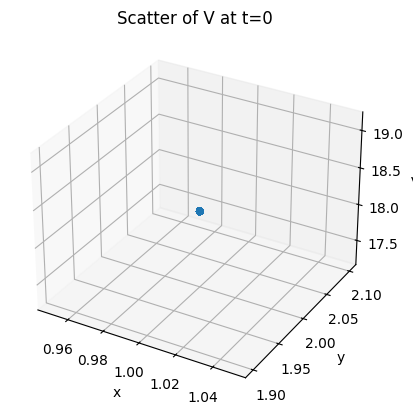

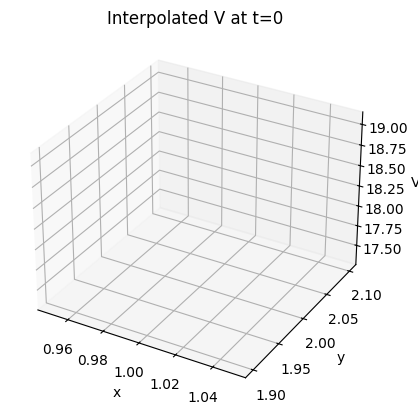

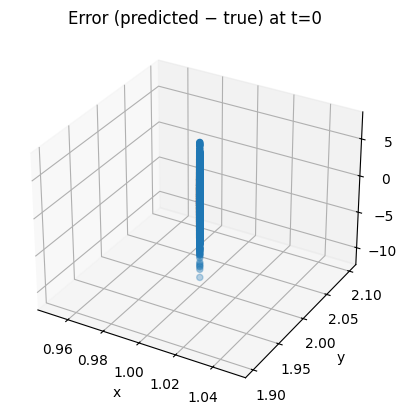

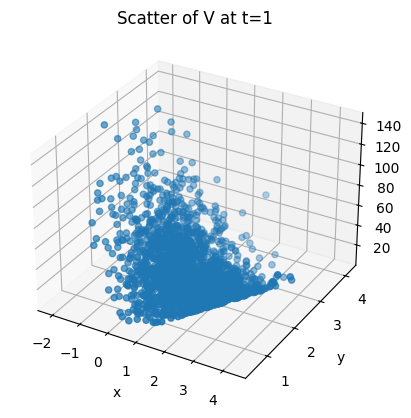

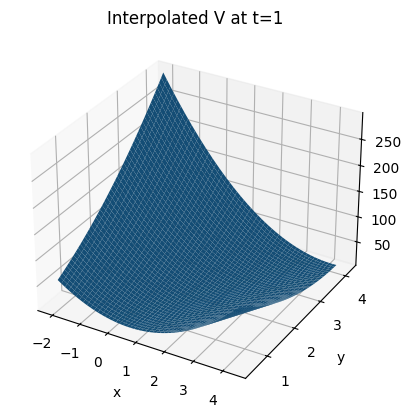

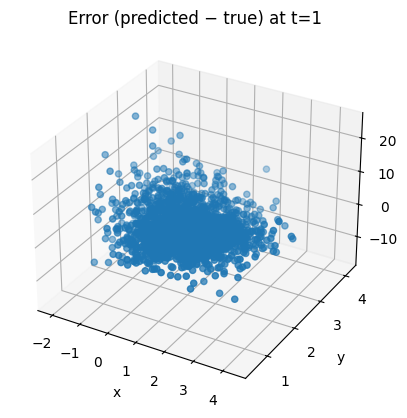

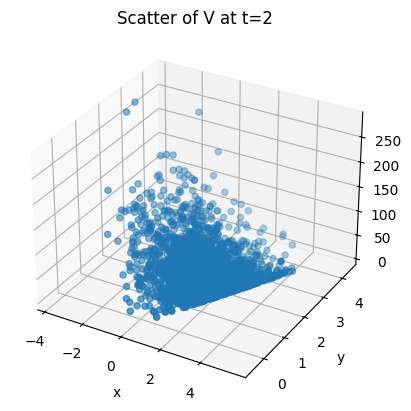

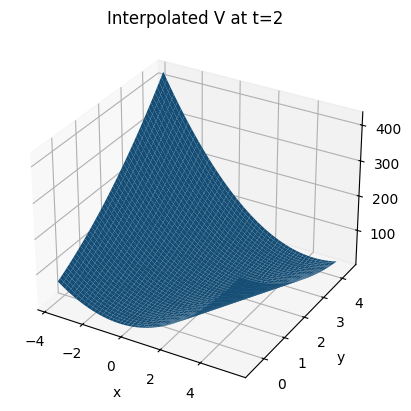

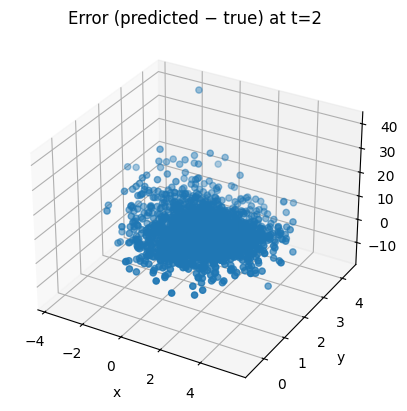

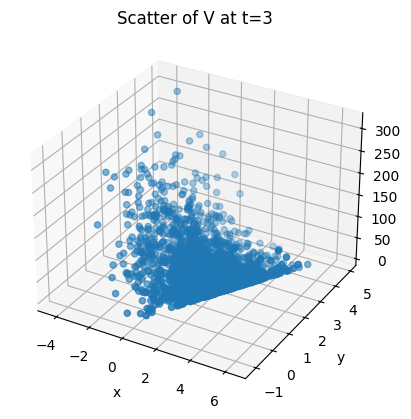

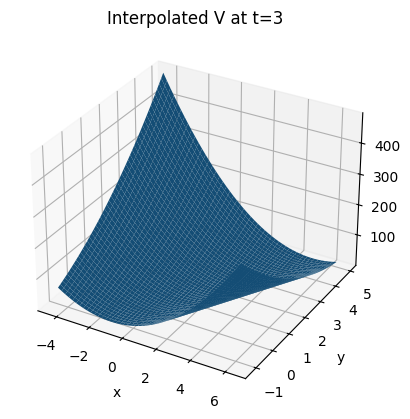

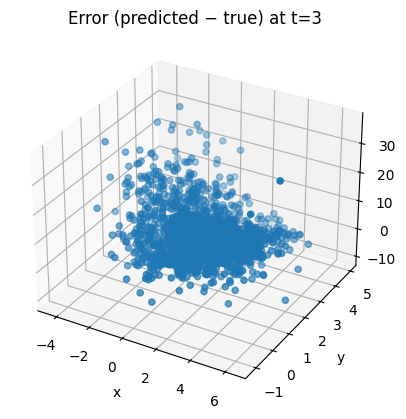

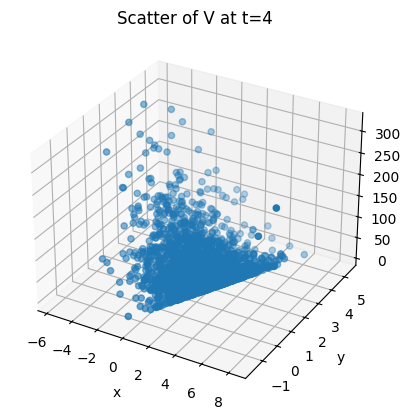

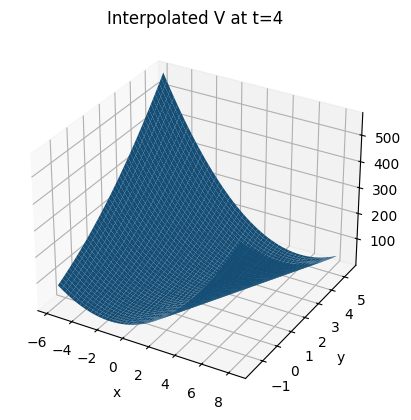

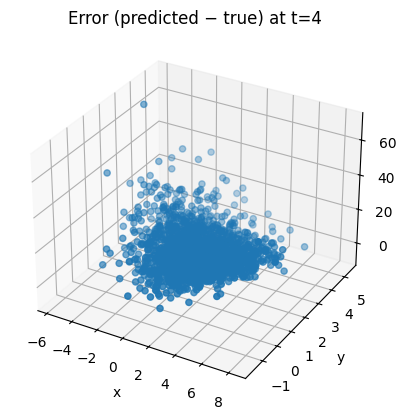

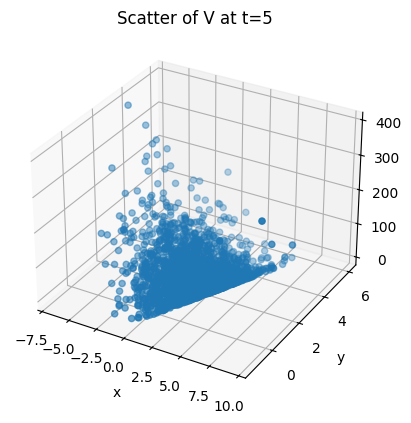

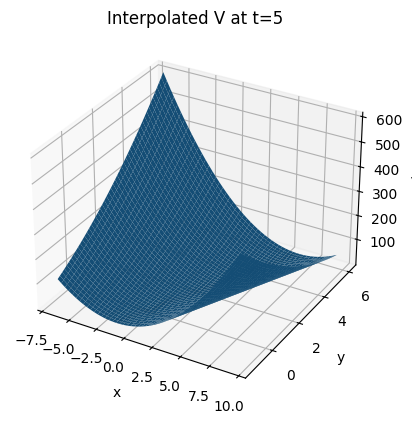

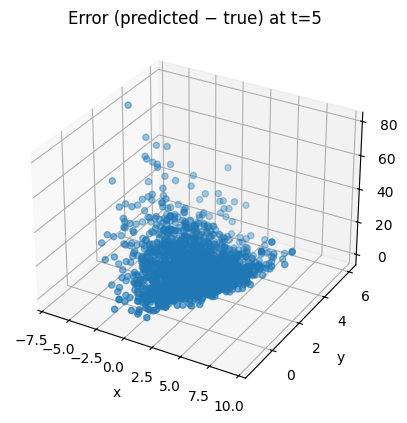

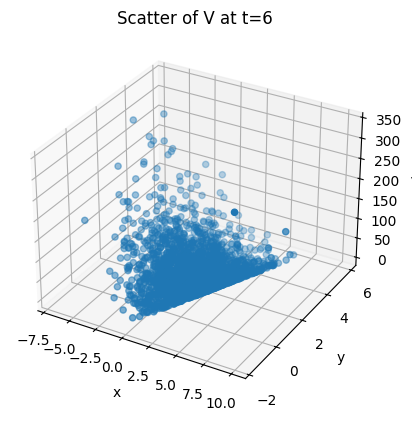

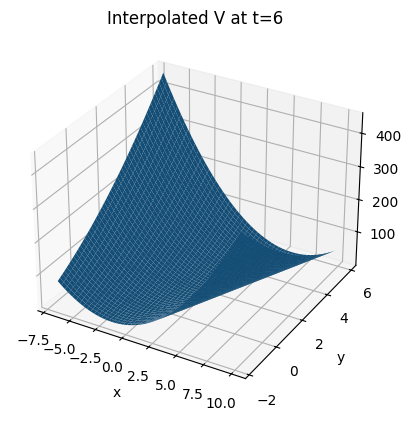

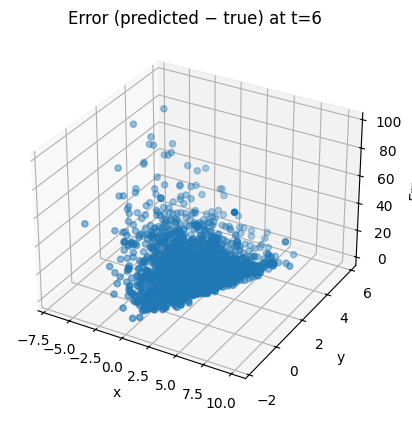

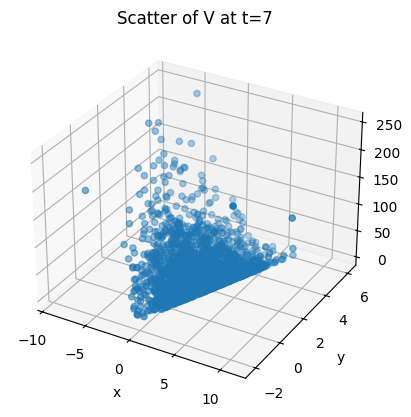

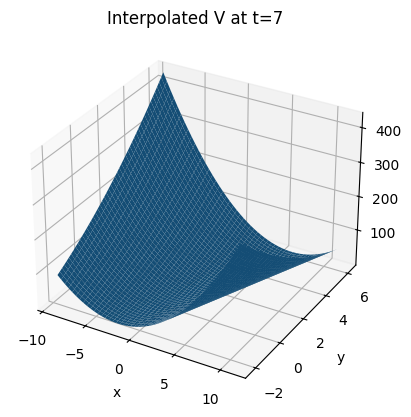

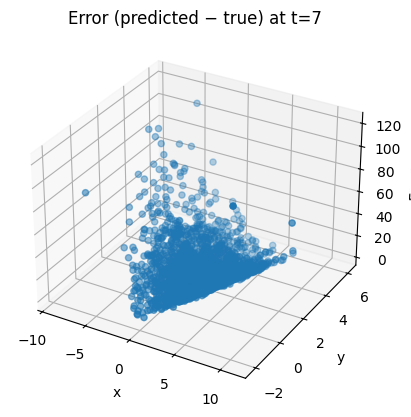

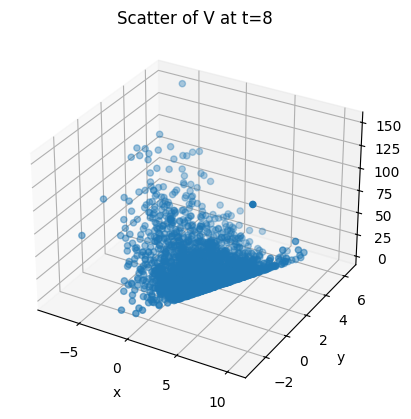

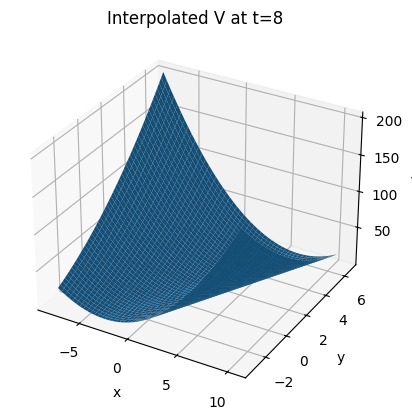

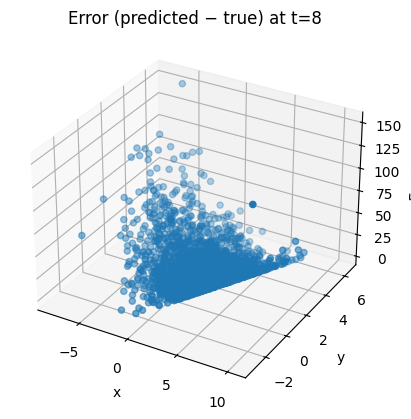

In [14]:
import torch, numpy as np, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal
import ot, time
from collections import namedtuple
import random

# Reproducibility
random.seed(12345)
np.random.seed(12345)
torch.manual_seed(12345)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Config
MEM_SIZE = 3000
BATCH_SIZE = 128
DISCOUNT = 1.0
N_INSTANCE = 1

Transition = namedtuple('Transition', ('time', 'x', 'y', 'value'))

class Memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def clear(self):
        self.memory.clear()
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def optimize_model(policy_net, memory, optimizer, trunc):
    if len(memory) < BATCH_SIZE:
        return None
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    values_batch = torch.stack(batch.value)
    x_batch = torch.stack(batch.x)
    y_batch = torch.stack(batch.y)
    time_batch = torch.stack(batch.time)

    preds = policy_net(time_batch, x_batch, y_batch)
    loss = nn.SmoothL1Loss()(preds, values_batch)

    optimizer.zero_grad()
    loss.backward()
    if trunc:
        for p in policy_net.parameters():
            p.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss

class Poly2(nn.Module):
    def __init__(self):
        super().__init__()
        # Features: [1, (T−t), (x−y)**2, (T−t)*(x−y)**2]
        self.coeffs = nn.Parameter(torch.zeros(4))

    def forward(self, time, x, y):
        tau = (time_horizon - time)
        diff2 = (x - y).pow(2)
        features = torch.cat([
            torch.ones_like(x),
            tau,
            diff2,
            tau * diff2
        ], dim=1)
        return features @ self.coeffs.unsqueeze(1)


# Simulation parameters
Trunc_flag = True
time_horizon = 8
smp_size = 2000
in_sample_size = 50
x_vol, y_vol = 1.0, 0.5
x_init, y_init = 1.0, 2.0
N_OPT = 500

final_result = np.zeros(N_INSTANCE)
start = Clock.time()


# Array to store true OT‑values for every (time, sample)
gt_vals = np.zeros((time_horizon+1, smp_size))

for inst in range(N_INSTANCE):
    val_hist = np.zeros(time_horizon+1)
    loss_hist = np.zeros(time_horizon+1)
    memory = Memory(MEM_SIZE)

    policy_net = Poly2().to(device)
    target_net = Poly2().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()
    optimizer = optim.Adam(policy_net.parameters(), lr=1e-2)

    x_pool = torch.full((smp_size, time_horizon+1, 1), x_init, device=device)
    y_pool = torch.full((smp_size, time_horizon+1, 1), y_init, device=device)

    for i in range(smp_size):
        for t in range(1, time_horizon+1):
            x_pool[i,t] = x_pool[i,t-1] + x_vol*torch.randn(1, device=device)
            y_pool[i,t] = y_pool[i,t-1] + y_vol*torch.randn(1, device=device)

    for t in range(time_horizon, -1, -1):
        for i in range(smp_size):
            x_dist = MultivariateNormal(x_pool[i,t], torch.eye(1, device=device)*x_vol**2)
            y_dist = MultivariateNormal(y_pool[i,t], torch.eye(1, device=device)*y_vol**2)
            next_x = x_dist.sample((in_sample_size,))
            next_y = y_dist.sample((in_sample_size,))

            x_batch = next_x.repeat_interleave(in_sample_size, dim=0)
            y_batch = next_y.repeat(in_sample_size, 1)
            l2 = torch.sum((x_batch - y_batch)**2, dim=1)

            if t == time_horizon:
                ev = 0.0
            elif t == time_horizon-1:
                cost = l2.reshape(in_sample_size, in_sample_size)
                ev = ot.emd2(np.ones(in_sample_size)/in_sample_size,
                             np.ones(in_sample_size)/in_sample_size,
                             cost.detach().cpu().numpy())
            else:
                v = target_net(torch.ones(x_batch.shape[0],1,device=device)*(t+1), x_batch, y_batch).reshape(-1)
                cost = (l2 + DISCOUNT*v).reshape(in_sample_size, in_sample_size)
                ev = ot.emd2(np.ones(in_sample_size)/in_sample_size,
                             np.ones(in_sample_size)/in_sample_size,
                             cost.detach().cpu().numpy())

            gt_vals[t, i] = ev

            memory.push(torch.tensor([t], device=device), x_pool[i,t], y_pool[i,t], torch.tensor([ev], device=device))

        best_loss = float('inf')
        patience = 50
        no_improve = 0

        for step in range(N_OPT):
            loss = optimize_model(policy_net, memory, optimizer, Trunc_flag)
            if loss is None:
                break
            curr = loss.item()
            loss_hist[t] += curr

            if curr + 1e-6 < best_loss:
                best_loss = curr
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break

        loss_hist[t] /= (step+1)
        target_net.load_state_dict(policy_net.state_dict())

        val_hist[t] = target_net(torch.zeros(1,1,device=device),
                                 x_pool[0,0].reshape(1,1),
                                 y_pool[0,0].reshape(1,1)).item()
        memory.clear()
        print(f"Time step {t}, loss {loss_hist[t]:.6f}")

    final_result[inst] = val_hist[0]
    print(f"Instance {inst}, V0 = {val_hist[0]:.6f}")

print("Results:", final_result)
print("Mean:", final_result.mean(), "Std:", final_result.std())
print("Avg time/instance:", (Clock.time()-start)/N_INSTANCE)

# ————— PLOTTING —————
for t in range(time_horizon+1):
    # Extract training points
    xs = x_pool[:, t, 0].cpu().numpy()
    ys = y_pool[:, t, 0].cpu().numpy()

    with torch.no_grad():
        V_pts = target_net(
            torch.full((len(xs),1), t, device=device),
            x_pool[:,t,:],
            y_pool[:,t,:]
        ).cpu().numpy().flatten()

    # 1️⃣ 3D Scatter
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, V_pts)
    ax.set_title(f"Scatter of V at t={t}")
    ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('V')
    plt.show()

    # 2️⃣ 3D Surface (interpolated on grid)
    x_lin = np.linspace(xs.min(), xs.max(), 50)
    y_lin = np.linspace(ys.min(), ys.max(), 50)
    Xg, Yg = np.meshgrid(x_lin, y_lin)
    grid_pairs = np.vstack([Xg.ravel(), Yg.ravel()]).T

    with torch.no_grad():
        time_grid = torch.full((grid_pairs.shape[0],1), float(t), device=device, dtype=torch.float32)
        x_grid = torch.tensor(grid_pairs[:,0], device=device, dtype=torch.float32).reshape(-1,1)
        y_grid = torch.tensor(grid_pairs[:,1], device=device, dtype=torch.float32).reshape(-1,1)

        V_grid = target_net(time_grid, x_grid, y_grid) \
                  .cpu().numpy().reshape(Xg.shape)


    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.plot_surface(Xg, Yg, V_grid)
    ax2.set_title(f"Interpolated V at t={t}")
    ax2.set_xlabel('x'); ax2.set_ylabel('y'); ax2.set_zlabel('V')
    plt.show()


    # 3️⃣ 3D Scatter of prediction error
    errors = V_pts - gt_vals[t]
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111, projection='3d')
    ax3.scatter(xs, ys, errors)
    ax3.set_title(f"Error (predicted − true) at t={t}")
    ax3.set_xlabel('x'); ax3.set_ylabel('y'); ax3.set_zlabel('Error')
    plt.show()


